# Mineração de Dados: Agrupamento

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:
...


In [2]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustertend
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale

## Análise exploratória

Primeiro, carregaremos os dados e analisaremos as distribuição das características dos grãos e as correlações entre elas.


In [3]:
df = pd.read_csv("data/trabalho4_dados_4.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            1143 non-null   int64  
 1   perimetro       1143 non-null   float64
 2   maior-eixo      1143 non-null   float64
 3   menor-eixo      1143 non-null   float64
 4   arredondamento  1143 non-null   float64
 5   area-convexa    1143 non-null   int64  
 6   extensao        1143 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.6 KB


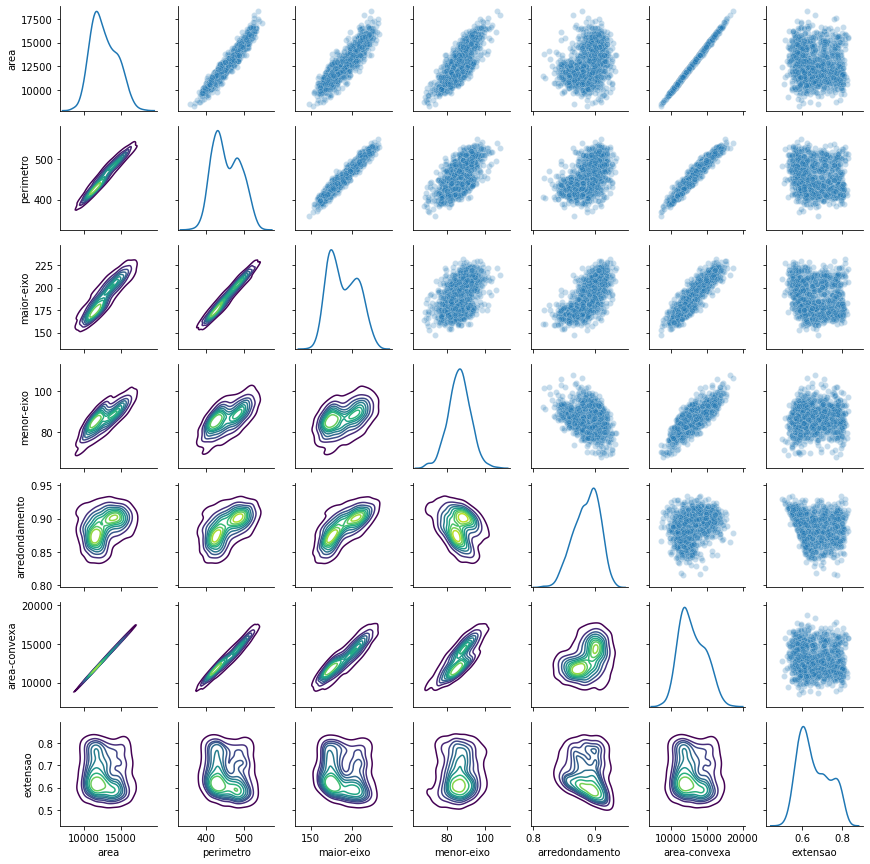

In [4]:
# Distribuição
g = sns.PairGrid(df, diag_sharey=False, height=1.75)
g.map_upper(sns.scatterplot, alpha=0.25)
g.map_lower(sns.kdeplot, cmap="viridis")
g.map_diag(sns.kdeplot);

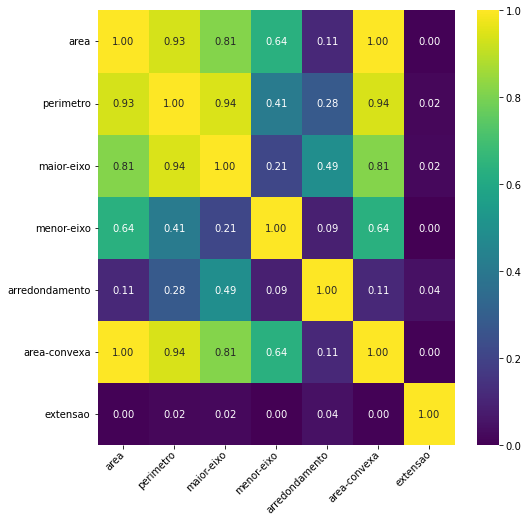

In [5]:
# Correlação linear (R^2)
plt.figure(figsize=(8, 8))
corr = df.corr()
g = sns.heatmap(corr ** 2, annot=True, vmin=0, vmax=1, fmt=".2f", cmap="viridis")
g.set_xticklabels(
    g.get_xticklabels(), rotation=45, va="center", ha="right", rotation_mode="anchor"
);

O primeiro gráfico revela duas informações interessantes:

- Em diversas das projeções, inclusive as unidimensionais, existem um ou dois picos de densidade bem definidos. Os dados projetados são facilmente separados em dois grupos. Visualmente, várias distribuições aparentam poder ser aproximadas por uma ou duas distribuições normais.
- Algumas das características são fortemente correlacionadas (linearmente). Nesse caso, as características são redundantes para a tarefa de agrupamento e podemos remover algumas delas.
  - O segundo gráfico exibe as correlações lineares através do índice $R^2$.


## Tendência de agrupamento

A seguir, verificaremos a aleatoriedade espacial dos dados através da estatística de Hopkins para diferentes configurações de características (100 vezes cada). Mas, antes, padronizaremos os dados.


In [6]:
# Padronizar os dados
X = pd.DataFrame()
X[df.columns] = scale(df[df.columns])
X.describe()

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
count,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03
mean,-3.590013e-16,1.272240e-15,1.225811e-16,6.478729e-16,3.847025e-15,2.121371e-16,-1.798892e-16
std,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00
min,-2.509628e+00,-2.693842e+00,-2.380168e+00,-3.183893e+00,-3.452512e+00,-2.465338e+00,-2.121627e+00
25%,-7.619569e-01,-7.912156e-01,-8.540997e-01,-6.369296e-01,-7.025409e-01,-7.709632e-01,-8.121555e-01
50%,-1.415949e-01,-1.476076e-01,-1.628963e-01,1.628585e-02,1.245985e-01,-1.280779e-01,-2.334658e-01
75%,7.434967e-01,8.031325e-01,8.563650e-01,6.295541e-01,7.648869e-01,7.596369e-01,7.760474e-01
max,3.181061e+00,2.603008e+00,2.439498e+00,3.583633e+00,2.293564e+00,3.166848e+00,2.215740e+00


In [7]:
column_combinations = [
    list(cols)
    for n_cols in range(2, len(X.columns) + 1)
    for cols in it.combinations(X.columns, n_cols)
]

In [8]:
H_SCORES_PATH = "data/h_scores.pkl"
try:
    with open(H_SCORES_PATH, "rb") as file:
        h_scores = pickle.load(file)
except FileNotFoundError:
    result = dict(cols=[], score=[])
    for cols in column_combinations:
        X_proj = X[list(cols)]
        for _ in range(100):
            result["cols"].append(frozenset(cols))
            result["score"].append(
                pyclustertend.hopkins(X_proj, sampling_size=len(X_proj))
            )
    result = pd.DataFrame(result)
    h_scores = pd.DataFrame()
    h_scores["mean"] = result.groupby("cols")["score"].mean()
    h_scores["std"] = result.groupby("cols")["score"].std()
    with open(H_SCORES_PATH, "wb") as file:
        pickle.dump(h_scores, file)

In [9]:
print("Projeções com H<0.5:", (h_scores["mean"] < 0.5).sum())
h_scores.sort_values(by="mean", ascending=True).head(n=5)

Projeções com H<0.5: 120


,mean,std
cols,,
"(area-convexa, area)",0.011505,0.000236
"(area-convexa, perimetro, area)",0.028419,0.000383
"(area-convexa, perimetro)",0.034838,0.000896
"(area, perimetro)",0.036361,0.001122
"(perimetro, maior-eixo)",0.038670,0.000978


A tabela acima mostra que as cinco melhores projeções de acordo com a estatística de Hopkins contêm apenas um topo na distribuição dos pontos (exceto, possivelmente, o último caso). Ao usar uma dessas projeções, a tendência é que haja um grupo principal e um grupo de 'outliers'. Isso porque a estatística de Hopkins testa apenas a uniformidade dos dados. A estatística sozinha não é apropriada para selecionar a melhor projeção.

Portanto, não faremos nenhum pré-processamento baseado nos melhores resultados de $H$. Escolheremos a combinação ótima das características na etapa a seguir.

## Algoritmos de agrupamento e otimização de parâmetros

Agora, analisaremos o desempenho de alguns algoritmos de agrupamento em diferentes configurações de características e parâmetros de modelo. Para isso, faremos uma busca em grade usando o _coeficiente da silhueta_ (usando a dissimilaridade do cosseno como distância) como critério de otimização.

A busca otimizará simultaneamente o algoritmo, seus parâmetros e as características de entrada. Cada configuração será testada 5 vezes.

> 1*: a dissimilaridade do cosseno foi escolhida com base em experimentos.
> 2: aqui, poderíamos limitar o espaço de busca de projeções de características usando os valores da estatística de Hopkins calculados na etapa anterior. Poderíamos também usar os valores de $R^2$ calculados na primeira etapa.

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        pass

    def transform(self, X, y=None):
        if self.columns is not None:
            X = X[self.columns]
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X, y)


def score_wrapper(pipe, X_test):
    estimator = pipe[-1]
    y = estimator.labels_
    if len(np.unique(y)) == 1:
        return -1
    return silhouette_score(X, y, metric="cosine")

In [11]:
SEARCH_RESULTS_PATH = "data/search_results.pkl"
try:
    with open(SEARCH_RESULTS_PATH, "rb") as file:
        search_results = pickle.load(file)
except FileNotFoundError:
    pipe = pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    search = GridSearchCV(
        pipe,
        param_grid=[
            {
                "select__columns": column_combinations,
                "estimator": [KMeans()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
            },
            {
                "select__columns": column_combinations,
                "estimator": [AgglomerativeClustering()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
                "estimator__linkage": ["ward", "complete", "average", "single"],
            },
            {
                "select__columns": column_combinations,
                "estimator": [DBSCAN()],
                "estimator__eps": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
            {
                "select__columns": column_combinations,
                "estimator": [OPTICS()],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
        ],
        scoring=score_wrapper,
        # Os dados DEVEM ser testados no conjunto de treino
        cv=[(list(range(len(X))), list(range(len(X))))] * 5,
        n_jobs=-1,
    )
    _ = search.fit(X)
    search_results = pd.DataFrame(search.cv_results_).sort_values(
        by="mean_test_score", ascending=False
    )
    with open(SEARCH_RESULTS_PATH, "wb") as file:
        pickle.dump(search_results, file)

In [12]:
best_result = search_results["params"][search_results.index[0]].copy()
best_result["select__columns"] = [best_result["select__columns"]]
pd.DataFrame(best_result)

,estimator,estimator__n_clusters,select__columns
0,KMeans(n_clusters=2),2,"[area, perimetro, maior-eixo, menor-eixo, arre..."


## Resultados

Analisemos agora os resultados. Primeiro, examinaremos o processo de busca de parâmetros. Depois, estudaremos os detalhes do agrupamento em si.


,param_estimator,mean_test_score,std_test_score,param_select__columns,rank_test_score
113,KMeans(n_clusters=2),0.643287,0.000227,"[area, perimetro, maior-eixo, menor-eixo, arre...",1
2181,AgglomerativeClustering(),0.642958,0.000000,"[area, perimetro, maior-eixo]",3
6407,DBSCAN(),0.188947,0.000000,"[maior-eixo, menor-eixo, area-convexa]",1316
13678,OPTICS(),0.005924,0.000000,"[perimetro, maior-eixo, menor-eixo, arredondam...",2368


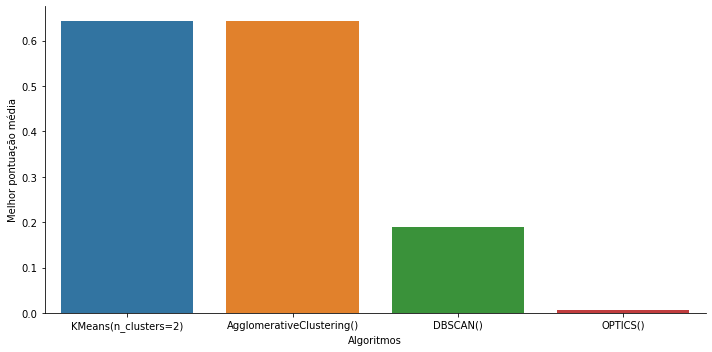

In [13]:
key = lambda x: str(search_results.loc[x, "param_estimator"])
group = search_results.groupby(key)
idx = group["mean_test_score"].transform(max) == search_results["mean_test_score"]
models_results = (
    search_results[idx]
    .sort_values("std_test_score")
    .sort_values("mean_test_score", ascending=False)
    .drop_duplicates("param_estimator")
)
models_results["model"] = models_results["param_estimator"].map(str)

g = sns.catplot(
    data=models_results,
    x="model",
    y="mean_test_score",
    kind="bar",
    aspect=2,
)
g.ax.set_xlabel("Algoritmos")
g.ax.set_ylabel("Melhor pontuação média")

models_results[
    [
        "param_estimator",
        "mean_test_score",
        "std_test_score",
        "param_select__columns",
        "rank_test_score",
    ]
]

In [24]:
for p in models_results["params"]:
    for k, v in p.items():
        print("\t" if k != "estimator" else "", k, ": ", v, sep="")

estimator: KMeans(n_clusters=2)
	estimator__n_clusters: 2
	select__columns: ['area', 'perimetro', 'maior-eixo', 'menor-eixo', 'arredondamento', 'extensao']
estimator: AgglomerativeClustering(linkage='average')
	estimator__linkage: average
	estimator__n_clusters: 2
	select__columns: ['area', 'perimetro', 'maior-eixo']
estimator: DBSCAN(eps=0.25, min_samples=20, p=2)
	estimator__eps: 0.25
	estimator__min_samples: 20
	estimator__p: 2
	select__columns: ['maior-eixo', 'menor-eixo', 'area-convexa']
estimator: OPTICS(min_samples=20)
	estimator__min_samples: 20
	estimator__p: 2
	select__columns: ['perimetro', 'maior-eixo', 'menor-eixo', 'arredondamento', 'area-convexa', 'extensao']


O gráfico acima mostra que o algoritmo KMeans, com determinado conjunto de parâmetros e características, obteve o melhor resultado de acordo com o coeficiente da silhueta.

Antes de continuarmos a análise dos algoritmos, vamos estudar a sensibilidade da qualidade dos resultados com relação à escolha das características.


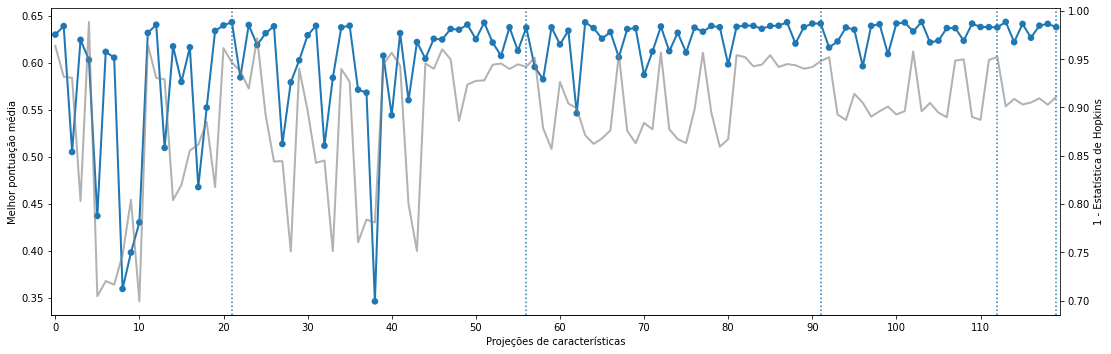

In [15]:
# Ordenar caractrerísticas de forma que elementos adjacentes
# estejam a uma modificação de distância
indices = [frozenset(column_combinations[0])]
curr_len = min(len(cols) for cols in column_combinations)
while len(indices) < len(column_combinations):
    n_appended = 0
    for cols in column_combinations:
        cols = frozenset(cols)
        last = indices[-1]
        if len(cols) != curr_len or cols in indices:
            continue
        if cols > last:
            distance = len(cols - last)
        else:
            distance = len(last - cols)
        if distance == 1:
            indices.append(cols)
            n_appended += 1
    if n_appended == 0:
        curr_len += 1

# Performance score
key = lambda x: frozenset(search_results.loc[x, "param_select__columns"])
group = search_results.groupby(key)

plt_data = pd.DataFrame(group["mean_test_score"].max())
kk = plt_data.copy()
plt_data = plt_data.reindex(indices)
plt_data["index"] = list(range(len(plt_data)))
plt_data["n_features"] = plt_data.index.map(len)

g = sns.catplot(
    data=plt_data,
    x="index",
    y="mean_test_score",
    kind="point",
    aspect=3,
    scale=0.75,
)
g.ax.set_xlabel("Projeções de características")
g.ax.set_ylabel("Melhor pontuação média")
for i, (x1, x2) in enumerate(zip(plt_data["n_features"], plt_data["n_features"][1:])):
    if x1 != x2:
        g.ax.axvline(x=i + 1, ls=":")

# H-score
plt_data = h_scores.reindex(plt_data.index)
ax2 = g.ax.twinx()
sns.pointplot(
    x=list(range(len(plt_data))),
    y=1 - plt_data["mean"],
    ax=ax2,
    color="grey",
    scale=0.75,
)
ax2.set_ylabel("1 - Estatística de Hopkins")
ax2.set_xticks(list(range(0, len(plt_data), 10)))
plt.setp(ax2.collections, alpha=0)
plt.setp(ax2.lines, alpha=0.6);

O gráfico acima possui uma propriedade especial: da esquerda para a direita, o número de características é crescente e entre quaisquer duas projeções adjacentes, o conjunto de características difere em exatamente uma coluna. Com isso, é possível observar tanto a sensibilidade global, quanto a sensibilidade a pequenas mudanças.

Podemos fazer as seguintes observações:

- A qualidade do agrupamento se altera significativamente com a mudança das características, especialmente quando o número de características é pequeno.
- A estatística de Hopkins é significativamente correlacionada com o coeficiente de silhueta, apesar de não ser capaz de prever a melhor configuração.

> Em um cenário mais complexo, poderíamos fazer uma busca de parâmetros iterativa, diminuindo o limiar de $H$ a cada iteração.


### Agrupamento

Analisemos agora o agrupamento de cada algoritmo em divsersas projeções do conjunto de dados, incluindo uma PCA.


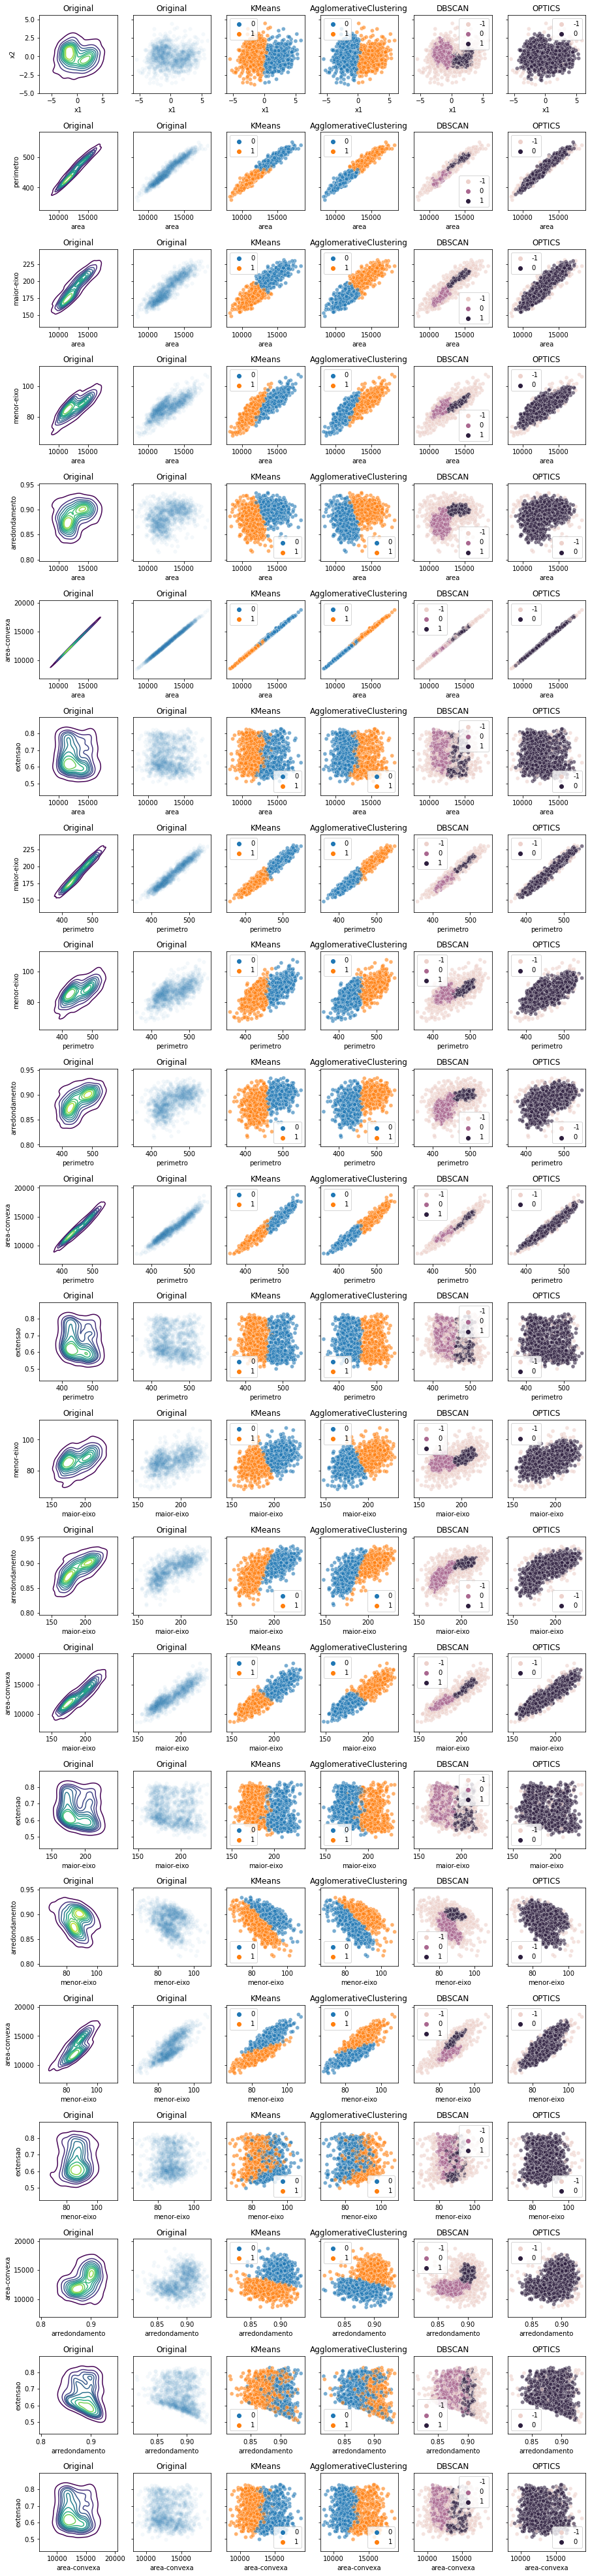

In [59]:
def make_estimator(params):
    pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    pipe.set_params(**params)
    return pipe


estimators = models_results["params"].map(make_estimator)
predictions = [estimator.fit_predict(X) for estimator in estimators]

pca_projection = PCA(n_components=2).fit_transform(X)
pca_projection = pd.DataFrame(pca_projection, columns=["x1", "x2"])
projections = [
    pca_projection,
    *[df[list(cols)] for cols in it.combinations(X.columns, 2)],
]

fig, ax = plt.subplots(
    nrows=len(projections),
    ncols=len(models_results) + 2,
    sharey="row",
    figsize=(15, 3.25 * len(projections)),
)
plt.subplots_adjust(hspace=0.5)
for j, data in enumerate(projections):
    g = sns.kdeplot(
        data=data, x=data.columns[0], y=data.columns[1], cmap="viridis", ax=ax[j, 0]
    )
    ax[j, 0].set_title("Original")
    g = sns.scatterplot(
        data=data,
        x=data.columns[0],
        y=data.columns[1],
        cmap="viridis",
        ax=ax[j, 1],
        alpha=0.05,
    )
    ax[j, 1].set_title("Original")
    for i, (estimator, y_pred) in enumerate(zip(estimators, predictions)):
        g = sns.scatterplot(
            data=data,
            x=data.columns[0],
            y=data.columns[1],
            hue=y_pred,
            alpha=0.6,
            ax=ax[j, i + 2],
        )
        g.set_title(str(estimator["estimator"]).split("(")[0])

O KMeans e o AgglomerativeClustering geraram agrupamentos semelhantes, que em geral são capazes de dividir os dados entre os dois picos de densidades das várias projeções. O DBSCAN conseguiu o mesmo, porém considerando os dados em regiões de baixa densidade como outliers*. O OPTICS agrupou os dados em elementos centrais e não-centrais.

O porquê de o comportamento do OPTICS e do DBSCAN ter sido diferente, bem como a influência da dissimilaridade do cosseno no processo de otimização são deixadas para estudos futuros.

Agora, vamos caracterizar os dados baseando-nos nos centros dos grupos gerados pelo KMeans.

> 1*: Esse comportamento só emergiu na otimização do coeficiente da silhueta com dissimilaridade do cosseno. Os agrupamentos para a otimização com distância euclidiana estão contidos na pasta `data`.

### Caracterização


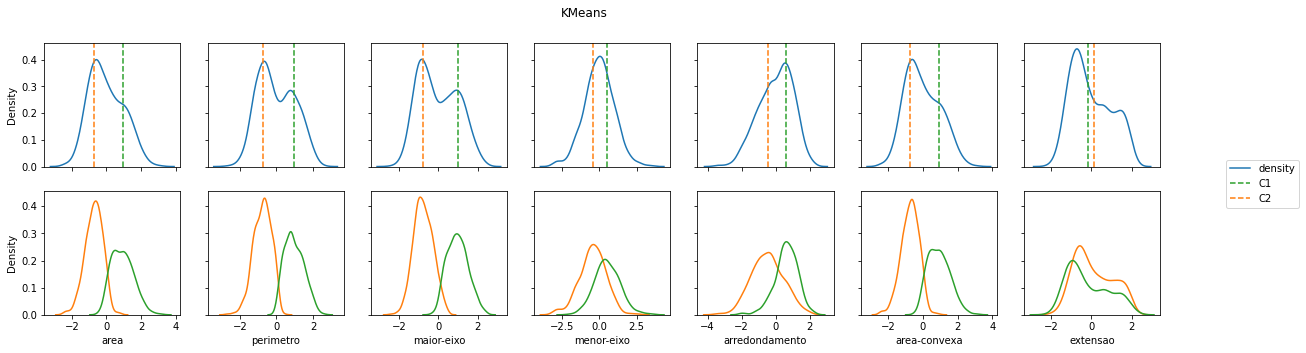

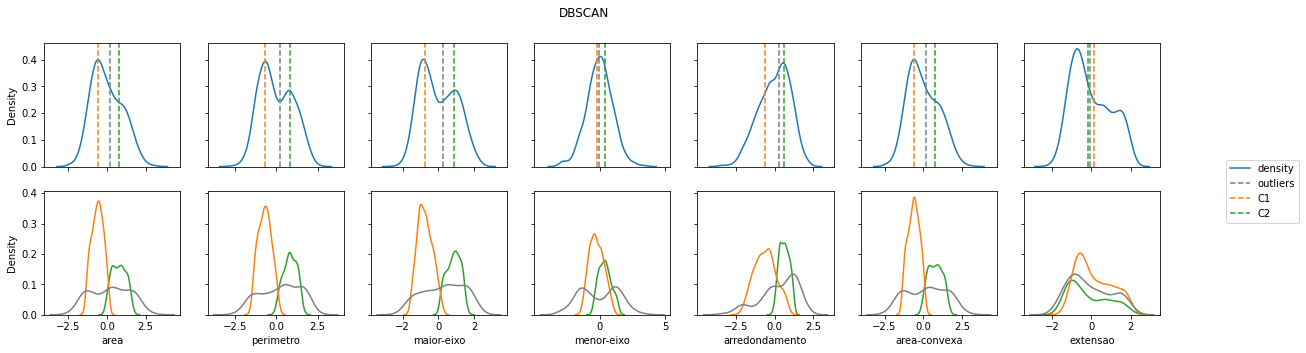

In [94]:
# KMeans
model = next(estimator for estimator in estimators if "KMeans" in str(estimator))[-1]
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(df.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:green", "tab:orange", "tab:purple"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k+1}" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )
fig.suptitle("KMeans");

# DBSCAN
model = next(estimator for estimator in estimators if "DBSCAN" in str(estimator))[-1]
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(X.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:gray", "tab:orange", "tab:green"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k}" if k > 0 else "outliers" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )
fig.suptitle("DBSCAN");

Observa-se que a distribuição da "extensão" não é muito diferente entre os dois grupos, apesar de ela poder ser aproximada pela soma de duas distribuições normais diferentes. Poderíamos criar um KMeans de dois grupos nesse eixo e cruzá-los com os grupos já existentes, criando 4 grupos no total.

> Baseado nas distribuições das características, poderíamos testar a significância estatística da diferença entre os grupos.

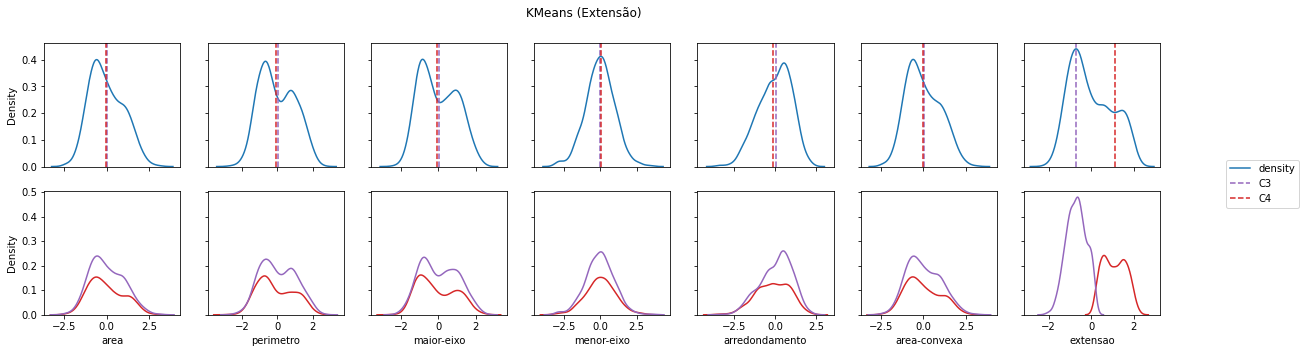

In [95]:
model = KMeans(n_clusters=2)
model.fit(X[["extensao"]])
model = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(X.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:purple", "tab:red"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(model):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k+3}" for k in range(len(model))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(model)],
        legend=None,
    )
fig.suptitle("KMeans (Extensão)");

In [152]:
model = next(estimator for estimator in estimators if "KMeans" in str(estimator))[-1]
centroids = NearestCentroid().fit(df, model.labels_).centroids_

stats = df.groupby(model.labels_, as_index=False).describe()
for i, col in enumerate(df.columns):
    for s in ["min", "25%", "50%", "75%", "max"] + ["count"] if i > 0 else []:
        stats.drop((col, s), axis=1, inplace=True)
stats

area                                                                 \
   count          mean          std      min      25%      50%      75%   
0  499.0  14365.448898  1119.481336  12006.0  13459.0  14306.0  15133.0   
1  644.0  11465.346273   908.045775   8328.0  10846.0  11519.0  12112.5   

             perimetro             maior-eixo           menor-eixo            \
       max        mean        std        mean       std       mean       std   
0  18313.0  490.438533  18.742111  206.249765  9.127082  89.769663  5.004237   
1  14142.0  428.244381  17.553116  175.955232  8.457278  84.086943  5.232469   

  arredondamento            area-convexa               extensao            
            mean       std          mean          std      mean       std  
0       0.899441  0.013911  14701.863727  1138.205105  0.647243  0.078475  
1       0.876905  0.019567  11716.285714   930.915562  0.668351  0.072662

In [153]:
model = KMeans(n_clusters=2)
model.fit(X[["extensao"]])
centroids = NearestCentroid().fit(X, model.labels_).centroids_

stats = df.groupby(model.labels_, as_index=False).describe()
for i, col in enumerate(df.columns):
    for s in ["min", "25%", "50%", "75%", "max"] + ["count"] if i > 0 else []:
        stats.drop((col, s), axis=1, inplace=True)
stats

area                                                                 \
   count          mean          std     min       25%      50%      75%   
0  701.0  12773.266762  1739.638886  8328.0  11443.00  12540.0  14115.0   
1  442.0  12665.117647  1780.045482  8505.0  11310.75  12352.0  13999.5   

             perimetro             maior-eixo            menor-eixo            \
       max        mean        std        mean        std       mean       std   
0  18313.0  457.272896  35.346014  190.110626  17.200955  86.441357  5.763087   
1  17564.0  452.420609  36.254672  187.706456  17.614375  86.768466  6.000135   

  arredondamento            area-convexa               extensao            
            mean       std          mean          std      mean       std  
0       0.888343  0.020059  13063.279601  1783.019842  0.606556  0.035204  
1       0.884208  0.021245  12950.585973  1831.711267  0.742525  0.040065